In [16]:
import scipy
from scipy.stats import median_abs_deviation as mad
import numpy as np
from matplotlib import pyplot as plt
import time
from scipy.io import loadmat as loadmat

In [17]:
rootfolder = ".."

Useful function for the plot

In [18]:
def display_band(X, par, epsi=0.001, col="k"):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght
    k = 0.01
    dx = x2 - x1
    dy = y2 - y1
    l = np.sqrt(dx**2 + dy**2)
    x1 = x1 - k * l
    x2 = x2 + k * l
    y1 = y1 - k * l
    y2 = y2 + k * l
    ##
    if np.abs(par[1]) < 2e-2:
        # disp('vertical line')
        a = np.vstack([-(par[1] * y1 + par[2]) / par[0], y1])
        b = np.vstack([-(par[1] * y2 + par[2]) / par[0], y2])
    else:
        a = np.vstack([x1, -(par[0] * x1 + par[2]) / par[1]])
        b = np.vstack([x2, -(par[0] * x2 + par[2]) / par[1]])

    if np.abs(par[0]) < 1e-5:
        v = np.array([0, 1])
    else:
        v = np.array([1, par[1] / par[0]])  # direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px, py, np.ones_like(px), colors=col, alpha=0.5)
    plt.gca().set_aspect("equal")


def display_clust(X, G, cmap):
    G = np.asarray(G, dtype=int)
    switch_out = 1
    smb = "o"
    col = []
    num_clust = int(np.max(G))

    for i in range(1, num_clust + 1):
        id = G == i
        id = id.squeeze()
        x = X[0, id]
        y = X[1, id]
        if len(col) == 0:
            plt.scatter(x, y, 80, cmap[i, :], marker=smb, edgecolors="k", alpha=1)
        else:
            plt.scatter(x, y, 50, col, marker=smb, edgecolors=col, alpha=0.1)
        if switch_out == 1:
            id = G == 0
            id = id.squeeze()
            plt.scatter(
                X[0, id],
                X[1, id],
                50,
                [0.3, 0.3, 0.3],
                marker=smb,
                edgecolors=[0.2, 0.2, 0.2],
                alpha=1,
            )

Function that computes the residual between points and a line

In [19]:
def res_line(X, M):
    if len(M.shape) > 1:
        num_lines = M.shape[1]
    else:
        num_lines = 1

    if num_lines == 1:
        d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
    else:
        n = X.shape[1]
        d = np.zeros((n, num_lines))
        for i in range(num_lines):
            d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
    
    return d

Functions to add outlier to the dataset

In [20]:
def addOutliersInBB(X, nOutliers, k=0.1):
    xmin = np.min(X[0, :])
    xmax = np.max(X[0, :])
    ymin = np.min(X[1, :])
    ymax = np.max(X[1, :])
    wx = xmax - xmin
    wy = ymax - ymin
    dx = k * wx
    dy = k * wy

    # Generate random offsets within the range [xmin - dx, xmax + dx] and [ymin - dy, ymax + dy]
    outlier_x = (xmax - xmin + 2 * dx) * np.random.uniform(size=(1, nOutliers)) + (xmin - dx)
    outlier_y = (ymax - ymin + 2 * dy) * np.random.uniform(size=(1, nOutliers)) + (ymin - dy)

    Y = np.hstack((X, np.vstack((outlier_x, outlier_y))))
    return Y

Ransac
------
Use the implementation from the last lecture

In [21]:
def fit_line_dlt(P):

    # Precondition = normalizing
    mx = np.mean(P[0, :])
    my = mx = np.mean(P[1, :])
    stdx = np.std(P[0, :])
    stdy = mx = np.std(P[1, :])

    # design matrix

    x_col = (P[0, :] - mx) / stdx
    y_col = (P[1, :] - my) / stdy
    ones_col = np.ones(P.shape[1])
    A = np.vstack((x_col, y_col, ones_col)).T  # A = [[x1,y1,1],[x2,y2,1],...,[xn,yn,1]]

    # vector of responses
    # y = P.T[:, 1]

    _, _, V = np.linalg.svd(A)

    theta = V.T[:, -1]

    # Invert precondition = denormalizing
    a = theta[0] / stdx
    b = theta[1] / stdy
    c = theta[2] - (((theta[0] * mx) / stdx) + ((theta[1] * my) / stdy))

    theta = np.array([a, b, c])

    residuals = A @ theta
    residual_error = np.sum(residuals**2)
    return theta, residuals, residual_error

In [22]:
def simpleRANSAC(X, eps, cardmss=2):
    """
    SIMPLERANSAC - Robust fit with the LMEDS algorithm
    X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
    eps: threshold for the residuals                # on paper called: E
    cardmss: cardinality of the minimal sample set  # on paper called: s
    """
    # number of samples in the dataset
    n = X.shape[1]
    # Desired probability of success
    alpha = 0.99 # on paper called: p -> high probability

    # Pessimistic estimate of inliers fraction
    f = 0.5     # on paper called: e -> probability of having 1 outlier

    # set maximum number of iterations
    MaxIterations = int(np.log(1 - alpha) / np.log(1 - (1-f)**cardmss))

    # set maximum consensus reached
    maxscore = 0

    for i in range(MaxIterations):

        # Generate cardmss random indices in the range 0..n-1 
        rand_choice = np.random.choice(n, cardmss, replace=False)
        mss = X[:, rand_choice]

        # Fit model to this minimal sample set.
        theta = fit_line_dlt(mss)[0]

        # Evaluate distances between points and model
        sqres = res_line(X, theta)

        # identify inliers: consensus set
        inliers = np.where(sqres < eps)[0]
        # samething, another method
        # inliers = np.where(np.abs(sqres) > eps, 0, 1) # 1 if inlier, 0 if outlier

        # assess consensus (the number of inliers)
        score = len(inliers)


        # replace maxscore, bestinliers and bestmodel if needed
        if score > maxscore:
            bestmodel = theta
            maxscore = score
            bestinliers = inliers

    return bestmodel, bestinliers

Sequential Ransac
-----------------
Prepare the dataset and set the parameters


## Stairs

In [23]:
epsi = 0.02  # inlier threshold for ransac

# temp = loadmat(f'{rootfolder}/data/star5.mat')
temp = loadmat(f"{rootfolder}/data/stair4.mat")

X = temp["X"]  # data
G = temp["G"]  # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2  # minimum number of points required to fit a model
kappa = 5  # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = "b"
temp = loadmat(f"{rootfolder}/data/cmap.mat")
cmap = temp["cmap"]

# add outliers
nOut = 100

# add outlier and update groundtruth
X = addOutliersInBB(X, nOut)

# update the label, considering that X previous command has appended nOut otliers
G = np.append(G, np.zeros(nOut))  # append zeros for new outliers

C:\Users\Angela\AppData\Local\Temp\ipykernel_14264\181113740.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, 80, cmap[i, :], marker=smb, edgecolors="k", alpha=1)
C:\Users\Angela\AppData\Local\Temp\ipykernel_14264\181113740.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


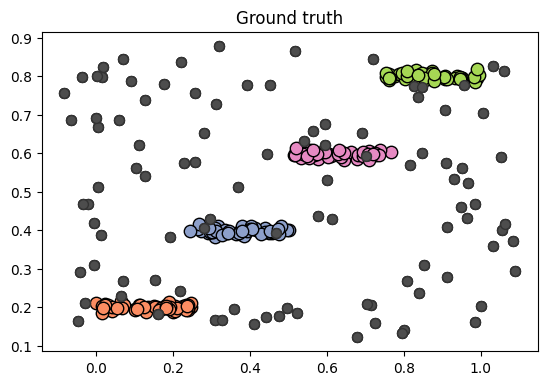

In [24]:
plt.figure(1)
display_clust(X, G, cmap)
plt.title("Ground truth")
plt.gca().set_aspect("equal")
plt.show()

Implement the sequential ransac algorithm

In [25]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, inliers = simpleRANSAC(Y, epsi, cardmss) # inliers = Ik
    refined_model = fit_line_dlt(Y[:, inliers])[0]
    # print(f"Model {cnt}: {refined_model}")
    # print(f"Inliers: {len(inliers)}")
    
    currentModel.append(refined_model) 
    currentInliers.append(inliers)

    if len(inliers) < E_min:
        break

    # remove current inliers
    Y = np.delete(Y, inliers, axis=1) # Y = Y/Ik

    # update iterations
    cnt += 1

# TODO: implement another stopping criteria based on the consensus of the last model found

Show the iteration of Sequential Ransac

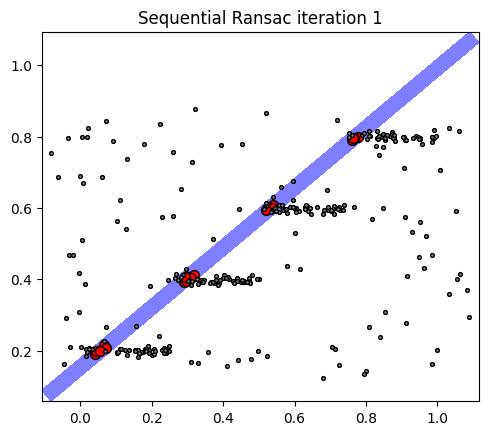

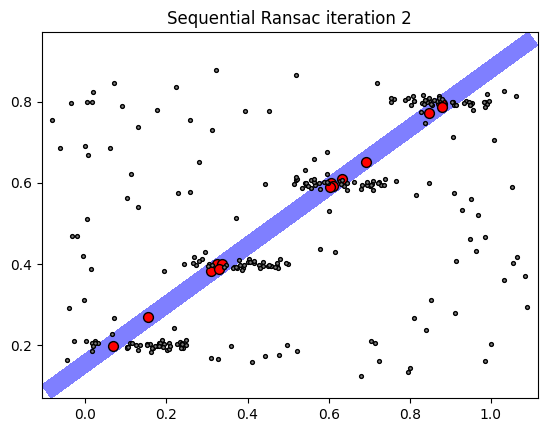

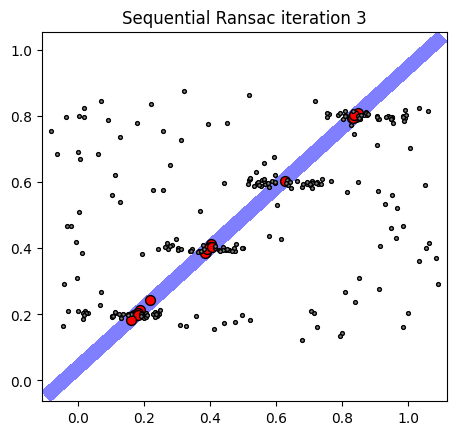

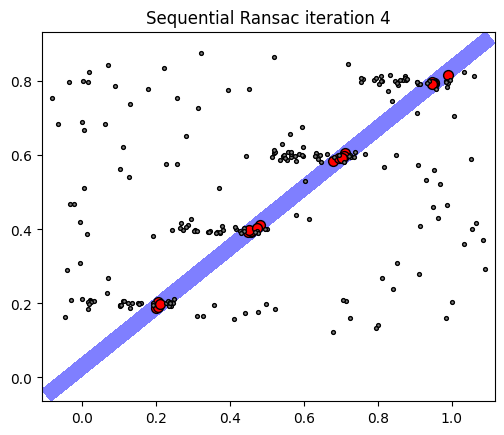

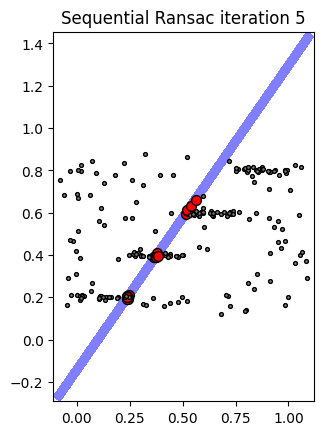

In [26]:
Y = X.copy()
plt.gca().set_aspect("equal")
for i in range(min(kappa, len(currentInliers))):

    # display_clust(X, G, cmap)

    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], epsi, col)

    # plot inliers for this model
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], 50, "r", marker="o", edgecolors="k")

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)

    # plot the remaining inliers in gray just for guidance
    plt.scatter(Y[0, :], Y[1, :], 30, "gray", marker=".", edgecolors="k")

    plt.title(f"Sequential Ransac iteration {i+1}")

    plt.show()

Trying different amount of outliers on star datasets

## Star

C:\Users\Angela\AppData\Local\Temp\ipykernel_14264\181113740.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, 80, cmap[i, :], marker=smb, edgecolors="k", alpha=1)
C:\Users\Angela\AppData\Local\Temp\ipykernel_14264\181113740.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


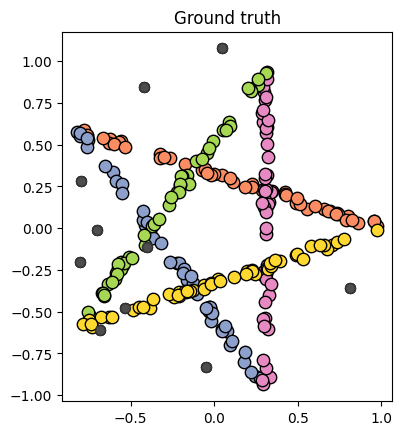

In [93]:
epsi = 0.02  # inlier threshold for ransac

temp = loadmat(f'{rootfolder}/data/star5.mat')

X = temp["X"]  # data
G = temp["G"]  # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2  # minimum number of points required to fit a model
kappa = 5  # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = "b"
temp = loadmat(f"{rootfolder}/data/cmap.mat")
cmap = temp["cmap"]

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X, nOut)

# update the label, considering that X previous command has appended nOut otliers
G = np.append(G, np.zeros(nOut))  # append zeros for new outliers

plt.figure(1)
display_clust(X, G, cmap)
plt.title("Ground truth")
plt.gca().set_aspect("equal")
plt.show()

In [100]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, inliers = simpleRANSAC(Y, epsi, cardmss) # inliers = Ik
    refined_model = fit_line_dlt(Y[:, inliers])[0]
    # print(f"Model {cnt}: {refined_model}")
    # print(f"Inliers: {len(inliers)}")
    
    currentModel.append(refined_model) 
    currentInliers.append(inliers)

    if len(inliers) < E_min:
        break

    # remove current inliers
    Y = np.delete(Y, inliers, axis=1) # Y = Y/Ik

    # update iterations
    cnt += 1

# TODO: implement another stopping criteria based on the consensus of the last model found

In [101]:
currentModel

[array([-1.21834417, -3.80451814,  1.19402433]),
 array([ 1.11410166, -0.8170582 ,  0.42050805]),
 array([-1.75627977,  5.39089056,  1.75384196]),
 array([ 1.21740356, -0.88795082,  0.47834123]),
 array([-1.50437625, -1.10889202, -0.60271068])]

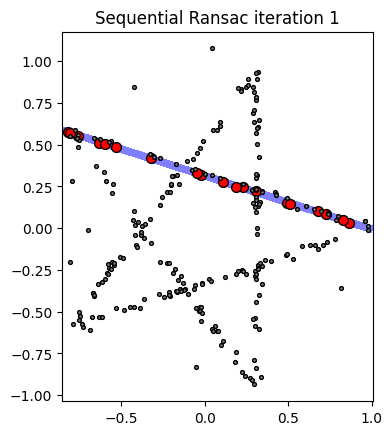

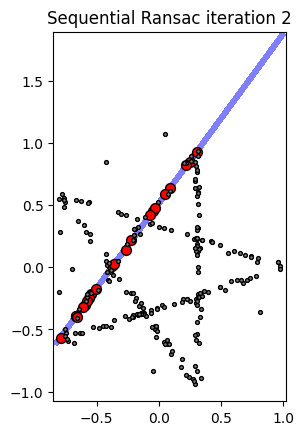

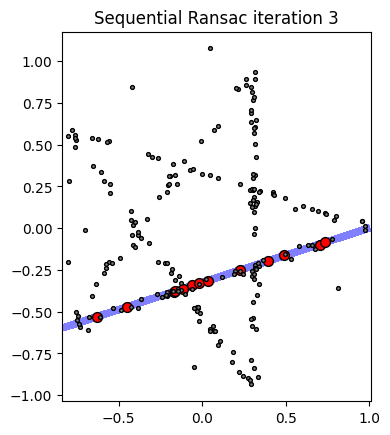

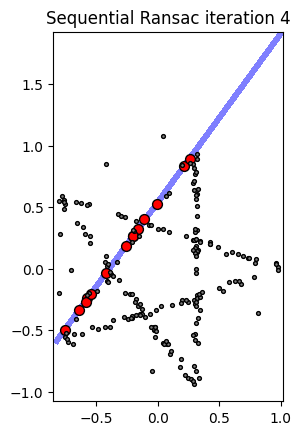

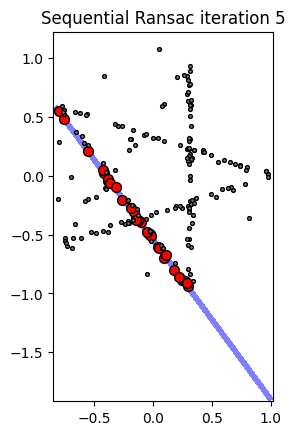

In [102]:
Y = X.copy()
plt.gca().set_aspect("equal")
for i in range(min(kappa, len(currentInliers))):
    # display_clust(X, G, cmap)

    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], epsi, col)

    # plot inliers for this model
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], 50, "r", marker="o", edgecolors="k")

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)
    
    # plot the remaining inliers in gray just for guidance
    plt.scatter(Y[0, :], Y[1, :], 30, "gray", marker=".", edgecolors="k")

    plt.title(f"Sequential Ransac iteration {i+1}")

    plt.show()

MultiModel fitting on circle
----------------------------
Implement Ransac (thus run Sequential Ransac) to fit circles

C:\Users\Angela\AppData\Local\Temp\ipykernel_14264\181113740.py:57: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, 80, cmap[i, :], marker=smb, edgecolors="k", alpha=1)
C:\Users\Angela\AppData\Local\Temp\ipykernel_14264\181113740.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


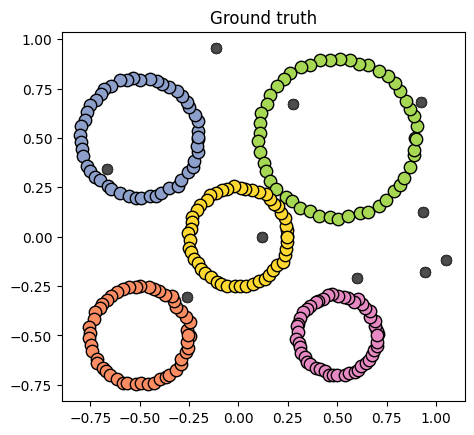

In [31]:
epsi = 0.02  # inlier threshold for ransac

temp = loadmat(f'{rootfolder}/data/circle5.mat')

X = temp["X"]  # data
G = temp["G"]  # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 3  # minimum number of points required to fit a model circle
kappa = 5  # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = "b"
temp = loadmat(f"{rootfolder}/data/cmap.mat")
cmap = temp["cmap"]

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X, nOut)

# update the label, considering that X previous command has appended nOut otliers
G = np.append(G, np.zeros(nOut))  # append zeros for new outliers

plt.figure(1)
display_clust(X, G, cmap)
plt.title("Ground truth")
plt.gca().set_aspect("equal")
plt.show()

We have a function to fit a line using Direct Linear Transformation (DLT), that fits a model to the equation of a line `ax+b`. But for circles the equation changes to `(x-a)^2 + (y-b)^2 = r^2`, so we'll need to create a function for this transform.


In [32]:
def fit_circle(points):
    A = np.zeros((len(points), 3))
    B = np.zeros((len(points), 1))
    for i, (x, y) in enumerate(points):
        A[i] = [x, y, 1]
        B[i] = x**2 + y**2
    C = np.linalg.lstsq(A, B, rcond=None)[0].flatten()
    cx = C[0] / 2
    cy = C[1] / 2
    r = np.sqrt(cx**2 + cy**2 + C[2])
    return cx, cy, r

def res_circle(points, cx, cy, r):
    residuals = []
    for x, y in points:
        distance = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
        residuals.append(abs(distance - r))
    return np.array(residuals)

def display_circle(Y, model, epsi, col):
    cx, cy, r = model
    theta = np.linspace(0, 2 * np.pi, 100)
    x = cx + r * np.cos(theta)
    y = cy + r * np.sin(theta)
    plt.plot(x, y, col)
    plt.fill_between(x, y - epsi, y + epsi, color=col, alpha=0.2)

And we also need to modify the RANSAC function to compute circles as well

In [33]:
def circlesRANSAC(X, eps, cardmss=2, line_or_circle="line"):
    """
    SIMPLERANSAC - Robust fit with the LMEDS algorithm
    X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
    eps: threshold for the residuals                # on paper called: E
    cardmss: cardinality of the minimal sample set  # on paper called: s
    """
    # number of samples in the dataset
    n = X.shape[1]
    # Desired probability of success
    alpha = 0.99 # on paper called: p -> high probability

    # Pessimistic estimate of inliers fraction
    f = 0.5     # on paper called: e -> probability of having 1 outlier

    # set maximum number of iterations
    MaxIterations = int(np.log(1 - alpha) / np.log(1 - (1-f)**cardmss))

    # set maximum consensus reached
    maxscore = 0

    for i in range(MaxIterations):

        # Generate cardmss random indices in the range 0..n-1 
        rand_choice = np.random.choice(n, cardmss, replace=False)
        mss = X[:, rand_choice].T

       
        cx, xy, r = fit_circle(mss)
        sqres = res_circle(X.T, cx, xy, r)
        theta = [cx, xy, r]

        # identify inliers: consensus set
        inliers = np.where(sqres < eps)[0]
        # samething, another method
        # inliers = np.where(np.abs(sqres) > eps, 0, 1) # 1 if inlier, 0 if outlier

        # assess consensus (the number of inliers)
        score = len(inliers)


        # replace maxscore, bestinliers and bestmodel if needed
        if score > maxscore:
            bestmodel = theta
            maxscore = score
            bestinliers = inliers

    return bestmodel, bestinliers

In [34]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, inliers = circlesRANSAC(Y, epsi, cardmss, "circle") # inliers = Ik
    # refined model?
    currentModel.append(model) 
    currentInliers.append(inliers)

    if len(inliers) < E_min:
        break

    # remove current inliers
    Y = np.delete(Y, inliers, axis=1) # Y = Y/Ik

    # update iterations
    cnt += 1

# TODO: implement another stopping criteria based on the consensus of the last model found

In [35]:
currentModel


[[0.49833335224049025, 0.5104837309082892, 0.3919611240742567],
 [-0.010568776551575095, 0.0033677658105236465, 0.24474100161462442],
 [-0.49374505679320396, 0.5061091391487139, 0.2957198892968485],
 [-0.5023992067999615, -0.5038690693083399, 0.24690652038869212],
 [0.5011452095069052, -0.5033736312769752, 0.20150628799715184]]

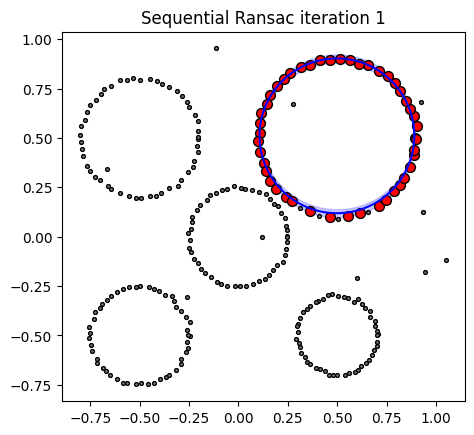

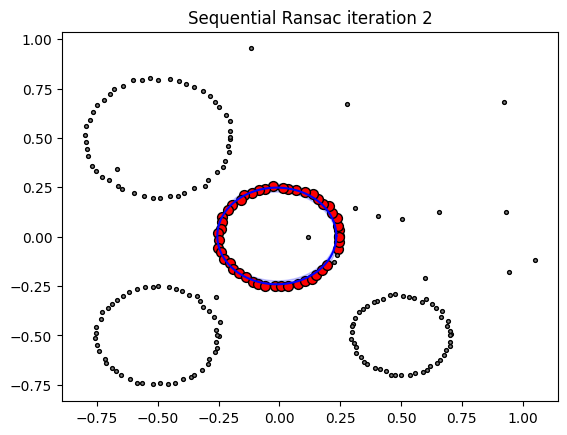

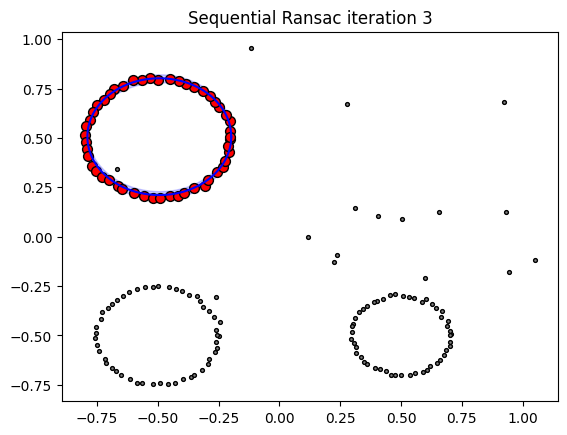

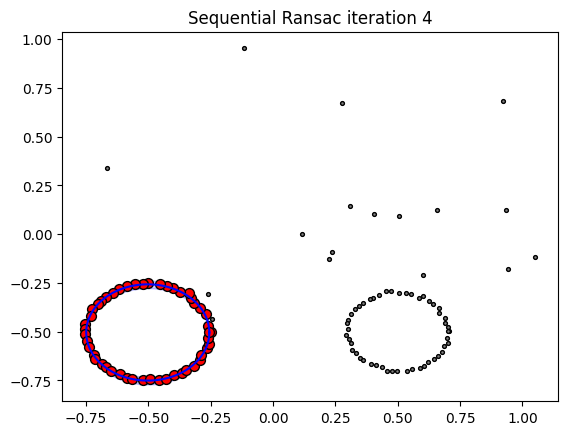

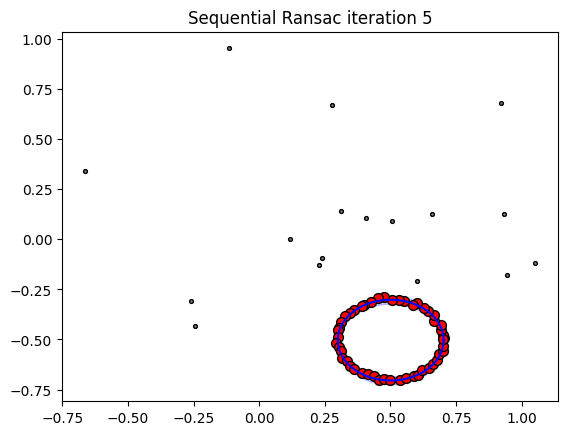

In [36]:
Y = X.copy()
plt.gca().set_aspect("equal")
for i in range(min(kappa, len(currentInliers))):

    # display a band for each model estimated (see display_circle function)
    display_circle(Y, currentModel[i], epsi, col)

    # plot inliers for this model
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], 50, "r", marker="o", edgecolors="k")

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)
    
    # plot the remaining inliers in gray just for guidance
    plt.scatter(Y[0, :], Y[1, :], 30, "gray", marker=".", edgecolors="k")

    plt.title(f"Sequential Ransac iteration {i+1}")

    plt.show()